In [1]:
import pandas as pd
import numpy as np
import urllib3
from bs4 import BeautifulSoup
import time
from datetime import date, datetime
from selenium import webdriver
import copy
from dateutil import relativedelta
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


## Functions

In [2]:
# get player's last name's initial
def last_initial(name):
    idx = name.find(' ')
    return(name[idx+1].capitalize())

In [3]:
#  get player's URL
def player_url(name):
    # in case of duplicate names, always choose the lastest
    prefix ='https://www.basketball-reference.com'
    url = 'https://www.basketball-reference.com/players/'
    soup = get_soup(url)
    
    # get into webpage with player's last name
    div = soup.find("div",{"id":"all_alphabet"})
    tags = div.find_all('a')
   
    name_list = [tags[i].text for i in range(len(tags))]
    url_ini=prefix+tags[name_list.index(last_initial(name))].attrs['href']
    
    # get into player's page
    soup = get_soup(url_ini)
    table = soup.find("table",{"id":"players"})
    tags = table.find_all('a')
    name_list = [tags[i].text for i in range(len(tags))]
    url_player=prefix+tags[[i for i, j in enumerate(name_list) if j == name.rstrip()][-1]].attrs['href']
    return url_player


In [50]:
# Scrap url
def get_soup(url):
    #time.sleep(1)
    driver = webdriver.Chrome("C:/Users/mysel/Downloads/chromedriver_win32/chromedriver.exe")
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, "lxml")
    driver.quit()
    return soup

In [416]:
# get season's name due to the date
def get_season(player_date):
    today = date.today()
    date_cmp = datetime.strptime('Sep 1, 2018', '%b %d, %Y').date().replace(year=today.year)
    parsed = datetime.strptime(player_date, '%b %d, %Y').date().replace(year=today.year)

    if parsed>date_cmp:
        season = datetime.strptime(player_date, '%b %d, %Y').year
    else:
        season = datetime.strptime(player_date, '%b %d, %Y').year-1
    return season+1

In [270]:
# get game data for specific player
def get_game_data(table_player, gamedate, player_name, player_team):
    # find url for the game
    tds = table_player.find_all('td', {"class":"left", "data-stat":"date_game"})
    game_list = [tds[i].text for i in range(len(tds))]
    idx = [idx for idx, x in enumerate(game_list) if x==gamedate]
    url_game = prefix + tds[idx[0]].find('a').attrs['href']
    
    #soup it
    soup = get_soup(url_game)
    
    # get ORtg and DRtg data from game
    team_name = player_team.lower()
    table = soup.find('div', {'id':['all_box_'+team_name+'_advanced']})
    game_table = read_table(table)
    new_header = game_table.iloc[0] 
    game_table = game_table[1:] 
    game_table.columns = new_header   
    idx = game_table.iloc[:,0].tolist().index(player_name) 
    a = game_table.iloc[idx,-2:].append(game_table.iloc[-1,-2:])
    a.index = ['ORtg', 'DRtg', 'OR_Team', 'DR_Team']
    return a


In [268]:
# get extended information
def get_possession_rating(df):
    extra = pd.DataFrame(columns=['ORtg', 'DRtg','OR_Team','DR_Team'])
    for i in range(len(df)):
        player_team = df['Tm'][i]
        game_date = df['Date'][i]
        player_name = df['Name'][i]
        a = get_game_data(soup_table_player, game_date, player_name, player_team) 
        extra = extra.append(a, ignore_index = True)       
    return extra.reset_index(drop = True)

In [6]:
# function for reading table
def read_table(table):
    n_cols = 0
    n_rows = 0
    # Initialize to generate an empyt table        
    for row in table.find_all('tr'):
        col_tags = row.find_all(["td", "th"])
        if len(col_tags) > 0:
            n_rows += 1
        if len(col_tags) > n_cols:
            n_cols = len(col_tags)
            
    # Create dataframe
    df = pd.DataFrame(index = range(0, n_rows), columns = range(0, n_cols))
            
    # Create list to store rowspan values 
    skip_index = [0 for i in range(0, n_cols)]

    # Start by iterating over each row in this table...
    row_counter = 0
    for row in table.find_all("tr"):
                
        # Skip row if it's blank
        if len(row.find_all(["td", "th"])) == 0:
            next
                
        else:   
            # Get all cells containing data in this row
            columns = row.find_all(["td", "th"])
            col_dim = []
            row_dim = []
            col_dim_counter = -1
            row_dim_counter = -1
            col_counter = -1
            this_skip_index = copy.deepcopy(skip_index)
                    
            for col in columns:
                        
                # Determine cell dimensions
                colspan = col.get("colspan")
                if colspan is None:
                    col_dim.append(1)
                else:
                    col_dim.append(int(colspan))
                col_dim_counter += 1
                            
                rowspan = col.get("rowspan")
                if rowspan is None:
                    row_dim.append(1)
                else:
                    row_dim.append(int(rowspan))
                row_dim_counter += 1
                            
                # Adjust column counter
                if col_counter == -1:
                    col_counter = 0  
                else:
                    col_counter = col_counter + col_dim[col_dim_counter - 1]
                            
                while skip_index[col_counter] > 0:
                    col_counter += 1

                # Get cell contents  
                cell_data = col.get_text()
                        
                # Insert data into cell
                df.iat[row_counter, col_counter] = cell_data

                # Record column skipping index
                if row_dim[row_dim_counter] > 1:
                    this_skip_index[col_counter] = row_dim[row_dim_counter]
        
            # Adjust row counter 
            row_counter += 1
                
            # Adjust column skipping index
            skip_index = [i - 1 if i > 0 else i for i in this_skip_index]    
            
    # get first row to header
    new_header = df.iloc[0] 
    df = df[1:] 
    df.columns = new_header   
    return(df)

## Get player's name and date

In [302]:
# get player's name and date

indexname ='C:/Users/mysel/Dropbox/datascience bootcamp/NBA/index2.csv'
event_index = pd.read_excel('index2.xlsx')


In [287]:
# get player's name and date
for kk in range(18,len(event_index)):
    player_name = event_index['Player '][kk].rstrip()
    player_date = event_index['Date'][kk]
    player_date = player_date.strftime('%b %d, %Y')
    player_event = event_index['Event'][kk]
    
    ####################get player's page
    url_player = player_url(player_name);
    
    ##################### get "advanced" table from player's index page
    soup = get_soup(url_player)
    soup_table_player_index = soup.find("table",{"id":"advanced"})
    player_index_table = read_table(soup_table_player_index)
    
    # get player+season url
    season = get_season(player_date)
    prefix ='https://www.basketball-reference.com'
    try:
        url_list = [soup_table_player_index.find_all('a')[i].attrs['href'] for i in range(len(soup_table_player_index.find_all('a')))]
        a = [i.find(str(season)) for i in url_list]
        url_player_year=prefix+url_list[next((i for i,x in enumerate(a) if x >0), None)]
        
    except:
        pass
    ##################### get stat_table for player's season
    soup = get_soup(url_player_year)
    soup_table_player = soup.find("table",{"id":"pgl_basic"})
    player_season_table = read_table(soup_table_player)
    
    # drop header rows
    a = player_season_table.Rk
    idx_drop =[i for i,x in enumerate(a) if x==list(player_season_table)[0]]
    player_season_table = player_season_table.drop(player_season_table.index[idx_drop]);

    # choose active rows
    a = player_season_table.G
    idx_choose = [i for i,x in enumerate(a) if len(x)]
    player_season_table = player_season_table.iloc[idx_choose]

    # reindex
    player_season_table = player_season_table.set_index('G') 

    # numerify
    player_season_table.iloc[:,9:] = player_season_table.iloc[:,9:].apply(pd.to_numeric)
    
    ########################### indexing pre-event and post-event games
    date_list = player_season_table['Date'].tolist()
    player_date_parsed = datetime.strptime(player_date, '%b %d, %Y').date()
    game_selected_pre =[]
    game_selected_post =[]
    for d in range(len(date_list)):
        dd = datetime.strptime(date_list[d], '%Y-%m-%d').date()
        if player_date_parsed < dd and player_date_parsed >= dd+relativedelta.relativedelta(months=-1):
            game_selected_post.append(d)
        if player_date_parsed <= dd+relativedelta.relativedelta(months=1) and player_date_parsed >= dd:
            game_selected_pre.append(d)
    if len(game_selected_pre)==0 or len(game_selected_post)==0:
        pass
    else:
    ########################### form new dataframe
        data = pd.DataFrame(columns = ['Name','Event','ED','Pre/Post'], index = range(len(game_selected_pre)+len(game_selected_post)))
        data['Name'] = [player_name for i in range(len(data))]
        data['Event'] = [player_event for i in range(len(data))]
        data['ED'] = [player_date_parsed.strftime('%Y-%m-%d') for i in range(len(data))]
        data['Pre/Post'] = ['Pre' for i in range(len(game_selected_pre))]+['Post' for i in range(len(game_selected_post))]
        data = pd.concat([data,player_season_table.iloc[game_selected_pre+game_selected_post].reset_index(drop = True)], axis = 1)
        data = data.rename(index=str, columns={"Age": "Offset"})
        data['Offset'] = [(datetime.strptime(data.Date[i], '%Y-%m-%d')-datetime.strptime(data.ED[i], '%Y-%m-%d')).days for i in range(len(data))]
    
    ########################## get additional data
        data_pr = get_possession_rating(data)
        data = pd.concat([data.reset_index(drop=True),data_pr.reset_index(drop=True)], axis=1)
    
    ########################## save as csv
   
        filename = player_name +'_'+ player_event+'_'+ event_index['Date'][kk].strftime('%Y%m%d')+'.csv'
        data.to_csv('C:/Users/mysel/Dropbox/datascience bootcamp/NBA/csv/'+filename)

# generate wordcloud figure

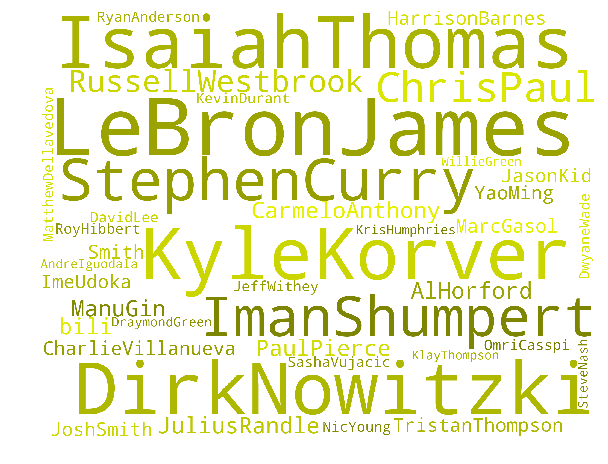

In [303]:
#array_for_word_cloud = []
#word_count_array = event_index['Player ']
#for idx, word in enumerate(feature_names):
#    array_for_word_cloud.append((word,word_count_array[idx]))
    
def random_color_func(word=None, font_size=None, 
                      position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

array_for_word_cloud = [sr.replace(" ", "") for sr in event_index['Player ']]

wordcloud = WordCloud(background_color='white',
          width=2600,
          height=2000,
          color_func=random_color_func).generate(' '.join(array_for_word_cloud))
%matplotlib inline
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,8))
ax.imshow(wordcloud)
plt.axis('off')
plt.show()
